<a href="https://colab.research.google.com/github/Gonca23-93/VD/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
w, h = 256,256
border = 5 
ids = next(os.walk("/content/drive/MyDrive/images"))[2]
print("No. of images = ", len(ids))

No. of images =  78


In [8]:
import glob
train = sorted(glob.glob("/content/drive/MyDrive/images/*"))
train_mask = sorted(glob.glob("/content/drive/MyDrive/masca/*"))
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 78
Total Mask Image : 78


In [9]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [47]:
# tqdm is used to display the progress bar
import cv2
for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    # Load images
    img = cv2.imread("/content/drive/MyDrive/images/"+id_, cv2.IMREAD_ANYDEPTH)
    x_img = np.array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    msk = cv2.imread("/content/drive/MyDrive/masca/"+id_, cv2.IMREAD_ANYDEPTH).astype(bool)
    mask = np.array(msk)
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Save images
    D = np.clip(x_img, 0, np.mean(x_img)+3*np.std(x_img))
    X[n] = x_img / (D * 255)
    y[n] = mask/255
    #X[n] = x_img /255

  0%|          | 0/78 [00:00<?, ?it/s]

In [48]:
print(X.shape, y.shape)

(78, 256, 256, 3) (78, 256, 256, 1)


In [49]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(62, 256, 256, 3) (62, 256, 256, 1) (16, 256, 256, 3) (16, 256, 256, 1)


40182

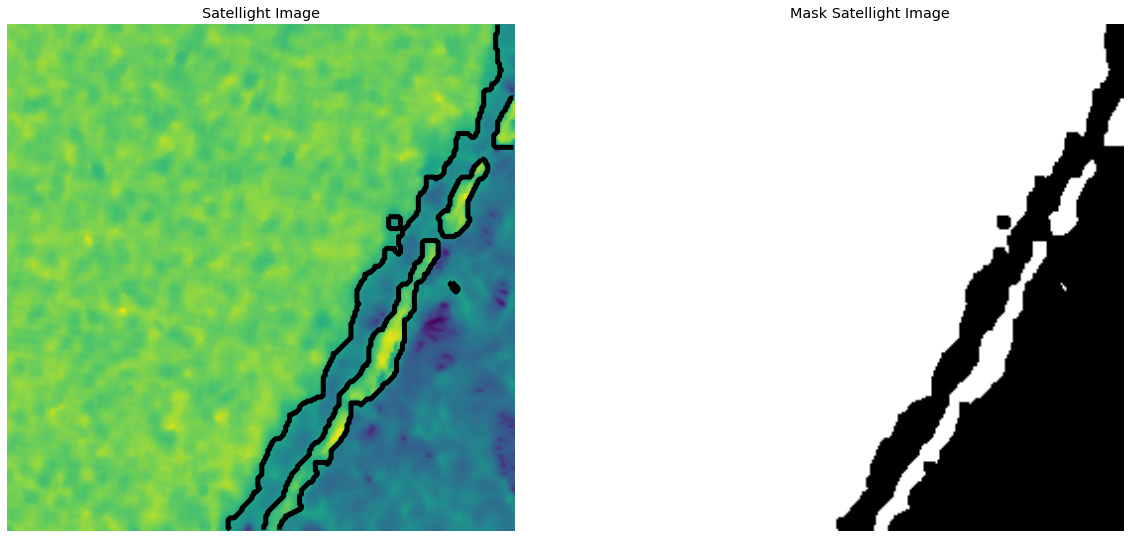

In [50]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellight Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellight Image')
ax2.set_axis_off()

In [51]:
def batch_Norm_Activation(x, BN=False): ## To Turn off Batch Normalization, Change BN to False >
    if BN == True:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    else:
        x= Activation("relu")(x)
    return x


def ResUnet(image_size):
    inputs = Input(shape=(image_size, image_size, 3))
    filters = 16
 
    # Encoder       
    conv = Conv2D(filters*1, kernel_size= (3,3), padding= 'same', strides= (1,1))(inputs)
    conv = batch_Norm_Activation(conv)
    conv = Conv2D(filters*1, kernel_size= (3,3), padding= 'same', strides= (1,1))(conv)
    shortcut = Conv2D(filters*1, kernel_size=(1,1), padding='same', strides=(1,1))(inputs)
    shortcut = batch_Norm_Activation(shortcut)
    output1 = add([conv, shortcut])
    
    res1 = batch_Norm_Activation(output1)
    res1 = Conv2D(filters*2, kernel_size= (3,3), padding= 'same', strides= (2,2))(res1)
    res1 = batch_Norm_Activation(res1)
    res1 = Conv2D(filters*2, kernel_size= (3,3), padding= 'same', strides= (1,1))(res1)
    shortcut1 = Conv2D(filters*2, kernel_size= (3,3), padding='same', strides=(2,2))(output1)
    shortcut1 = batch_Norm_Activation(shortcut1)
    output2 = add([shortcut1, res1])
    
    res2 = batch_Norm_Activation(output2)
    res2 = Conv2D(filters*4, kernel_size= (3,3), padding= 'same', strides= (2,2))(res2)
    res2 = batch_Norm_Activation(res2)
    res2 = Conv2D(filters*4, kernel_size= (3,3), padding= 'same', strides= (1,1))(res2)
    shortcut2 = Conv2D(filters*4, kernel_size= (3,3), padding='same', strides=(2,2))(output2)
    shortcut2 = batch_Norm_Activation(shortcut2)
    output3 = add([shortcut2, res2])
    
    res3 = batch_Norm_Activation(output3)
    res3 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides= (2,2))(res3)
    res3 = batch_Norm_Activation(res3)
    res3 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides= (1,1))(res3)
    shortcut3 = Conv2D(filters*8, kernel_size= (3,3), padding='same', strides=(2,2))(output3)
    shortcut3 = batch_Norm_Activation(shortcut3)
    output4 = add([shortcut3, res3])
    
    res4 = batch_Norm_Activation(output4)
    res4 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (2,2))(res4)
    res4 = batch_Norm_Activation(res4)
    res4 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (1,1))(res4)
    shortcut4 = Conv2D(filters*16, kernel_size= (3,3), padding='same', strides=(2,2))(output4)
    shortcut4 = batch_Norm_Activation(shortcut4)
    output5 = add([shortcut4, res4])
    
    #bridge
    conv = batch_Norm_Activation(output5)
    conv = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (1,1))(conv)
    conv = batch_Norm_Activation(conv)
    conv = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (1,1))(conv)
    
    #decoder
   
    uconv1 = UpSampling2D((2,2))(conv)
    uconv1 = concatenate([uconv1, output4])
    
    uconv11 = batch_Norm_Activation(uconv1)
    uconv11 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv11)
    uconv11 = batch_Norm_Activation(uconv11)
    uconv11 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv11)
    shortcut5 = Conv2D(filters*16, kernel_size= (3,3), padding='same', strides=(1,1))(uconv1)
    shortcut5 = batch_Norm_Activation(shortcut5)
    output6 = add([uconv11,shortcut5])
   
    uconv2 = UpSampling2D((2,2))(output6)
    uconv2 = concatenate([uconv2, output3])
    
    uconv22 = batch_Norm_Activation(uconv2)
    uconv22 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv22)
    uconv22 = batch_Norm_Activation(uconv22)
    uconv22 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv22)
    shortcut6 = Conv2D(filters*8, kernel_size= (3,3), padding='same', strides=(1,1))(uconv2)
    shortcut6 = batch_Norm_Activation(shortcut6)
    output7 = add([uconv22,shortcut6])
    
    uconv3 = UpSampling2D((2,2))(output7)
    uconv3 = concatenate([uconv3, output2])
   
    uconv33 = batch_Norm_Activation(uconv3)
    uconv33 = Conv2D(filters*4, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv33)
    uconv33 = batch_Norm_Activation(uconv33)
    uconv33 = Conv2D(filters*4, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv33)
    shortcut7 = Conv2D(filters*4, kernel_size= (3,3), padding='same', strides=(1,1))(uconv3)
    shortcut7 = batch_Norm_Activation(shortcut7)
    output8 = add([uconv33,shortcut7])
    
    uconv4 = UpSampling2D((2,2))(output8)
    uconv4 = concatenate([uconv4, output1])
    
    uconv44 = batch_Norm_Activation(uconv4)
    uconv44 = Conv2D(filters*2, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv44)
    uconv44 = batch_Norm_Activation(uconv44)
    uconv44 = Conv2D(filters*2, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv44)
    shortcut8 = Conv2D(filters*2, kernel_size= (3,3), padding='same', strides=(1,1))(uconv4)
    shortcut8 = batch_Norm_Activation(shortcut8)
    output9 = add([uconv44,shortcut8])
    
    output_layer = Conv2D(1, (3, 3), padding="same", activation="softmax")(output9)
    model = Model(inputs, output_layer)
  
    return model

In [52]:
from keras import backend as K
K.clear_session()

# input_img = Input((h, w, 3), name='img')
model = ResUnet(image_size = 256)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)

In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [55]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-ResUnet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=2, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)


Epoch 1/2
11/11 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.0000e+00 - auc: 0.5000 - sensitivity_at_specificity: 0.0000e+00 - specificity_at_sensitivity: 0.0000e+00 
Epoch 1: val_loss improved from inf to 0.07288, saving model to model-ResUnet.h5
11/11 [==============================] - 188s 17s/step - loss: 0.1806 - accuracy: 0.0000e+00 - auc: 0.5000 - sensitivity_at_specificity: 0.0000e+00 - specificity_at_sensitivity: 0.0000e+00 - val_loss: 0.0729 - val_accuracy: 0.0000e+00 - val_auc: 0.5000 - val_sensitivity_at_specificity: 0.0000e+00 - val_specificity_at_sensitivity: 0.0000e+00 - lr: 0.0010
Epoch 2/2
 4/11 [=========>....................] - ETA: 1:55 - loss: 0.0605 - accuracy: 0.0000e+00 - auc: 0.5000 - sensitivity_at_specificity: 0.0000e+00 - specificity_at_sensitivity: 0.0000e+00

In [20]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,lr
1,0.032212,0.0,0.5,0.0,0.0,0.019508,0.0,0.5,0.0,0.0,0.001
0,0.247710,0.0,0.5,0.0,0.0,0.063631,0.0,0.5,0.0,0.0,0.001


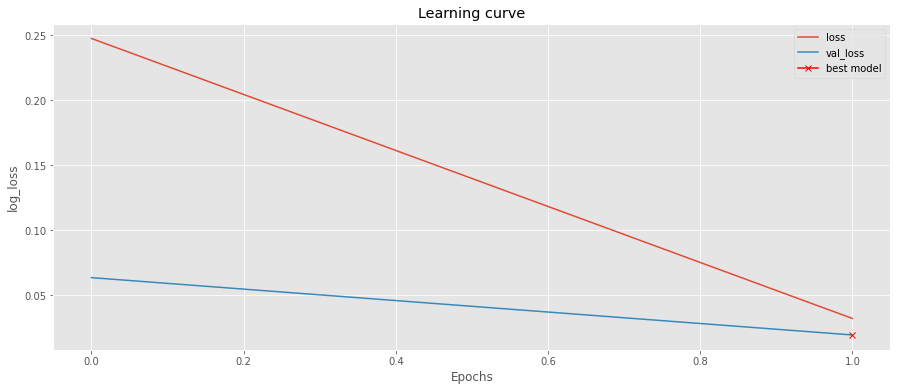

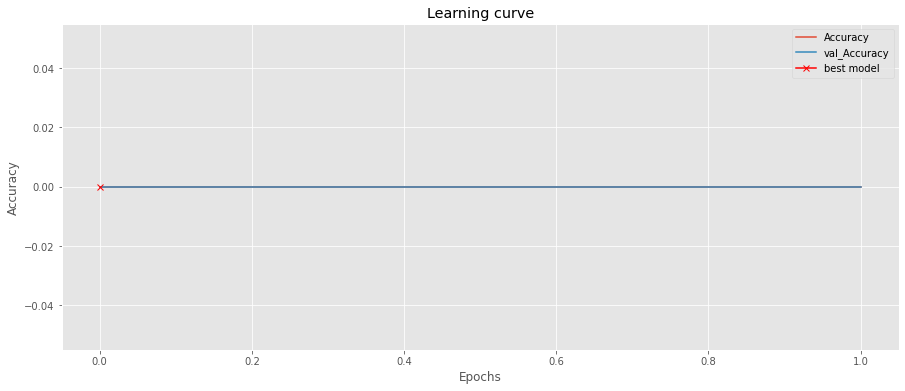

In [21]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [22]:
model.load_weights('model-ResUnet.h5')


In [23]:
model.evaluate(X_test, y_test, verbose=1)


1/1 [==============================] - 13s 13s/step - loss: 0.0195 - accuracy: 0.0000e+00 - auc: 0.5000 - sensitivity_at_specificity: 0.0000e+00 - specificity_at_sensitivity: 0.0000e+00


[0.019507654011249542, 0.0, 0.5, 0.0, 0.0]

In [24]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

1/1 [==============================] - 10s 10s/step


In [25]:
# Threshold predictions
preds_train_t = (preds_train > 0.5)
preds_val_t = (preds_val > 0.5)

In [26]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellight Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Satellight Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), cmap='seismic')
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Satelight Image Predicted')
    ax[2].set_axis_off()
    
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Satellight Mask Image Predicted binary');
    ax[3].set_axis_off()   

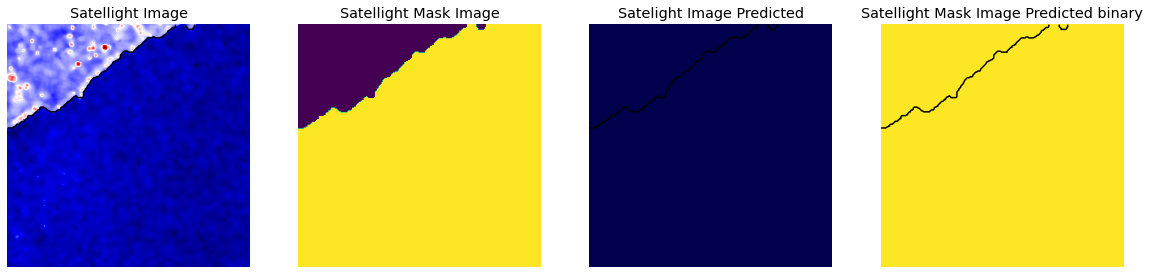

In [32]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_val_t, ix=1)

In [45]:
#Testar e tentar prever
def predict(input_dir_test, model_dir_test, result_dir_test, input_channel_count, Batch_size, First_layer_filter_count):
    # Import Opencv to save result images
    import cv2



    output_channel_count = 1
    network = ResUnet(256)
    model.load_weights('model-ResUnet.h5')


    Y_pred = model.predict(X_test, Batch_size)
    # Note: Y_pred has an image size of 256x256

    # Output into result_dir_test
    for i, y in enumerate(Y_pred):
        img = x_img

        if i < 10:
            cv2.imwrite(result_dir_test+os.sep+'prediction00' + str(i) + '_o.png', denormalize_x(X_test[i]))
            cv2.imwrite(result_dir_test+os.sep+'prediction00' + str(i) + '_p.png', denormalize_y(y))
        if i >= 10 and i < 100:
            cv2.imwrite(result_dir_test+os.sep+'prediction0' + str(i) + '_o.png', denormalize_x(X_test[i]))
            cv2.imwrite(result_dir_test+os.sep+'prediction0' + str(i) + '_p.png', denormalize_y(y))
        if i >= 100:
            cv2.imwrite(result_dir_test+os.sep+'prediction' + str(i) + '_o.png', denormalize_x(X_test[i]))
            cv2.imwrite(result_dir_test+os.sep+'prediction' + str(i) + '_p.png', denormalize_y(y))

    #
    # Prediction #
    #
    
    
    

In [44]:
    # Convert normalized value to 0 to 255
    def denormalize_x(image):
        image = image*127.5 + 127.5
        return image

        # Convert normalized value to 0 to 255
    def denormalize_y(image):
        image = image*255
        return image

In [46]:
Batch_size = 8
First_layer_filter_count = 32
input_channel_count = 3
print("Prediction...")
input_dir_test = '/content/drive/MyDrive/images'
model_dir_test = 'model-ResUnet.h5'
result_dir_test = '/content/drive/MyDrive/tes'

predict(input_dir_test, model_dir_test, result_dir_test, input_channel_count, Batch_size, First_layer_filter_count)

Prediction...
2/2 [==============================] - 13s 7s/step
